# Solving Hydrogen Atom problem with Python 

In [1]:
from scipy import *
from scipy import integrate
from scipy import optimize
from numpy import *
import matplotlib.pyplot as plt 
plt.style.use('classic')

C:\HRISHIT\jupyter notebook\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def Schroed_deriv(y,r,l,En):
    "Given y=[u,u'] returns dy/dr=[u',u''] "
    (u,up) = y
    return array([up, (l*(l+1)/r**2-2/r-En)*u])

R = linspace(1e-10,20,500)
l=0
E0=-1.0

ur = integrate.odeint(Schroed_deriv, [0.0, 1.0], R, args=(l,E0))

In [3]:
from pylab import *

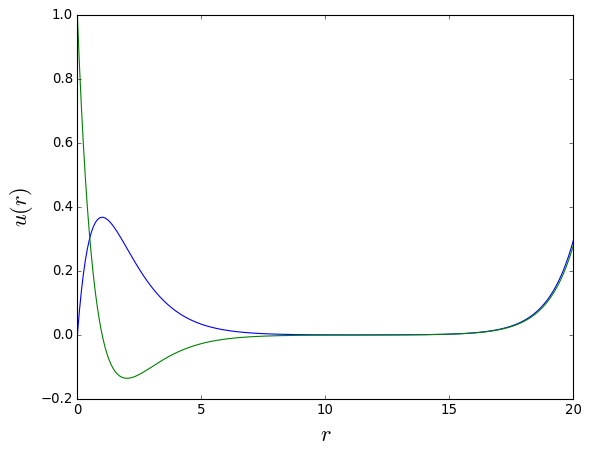

In [4]:
plt.figure(facecolor='white')
plt.plot(R, ur)
plt.ylabel('$u(r)$', size=20)
plt.xlabel('$r$', size=20)
plt.show()

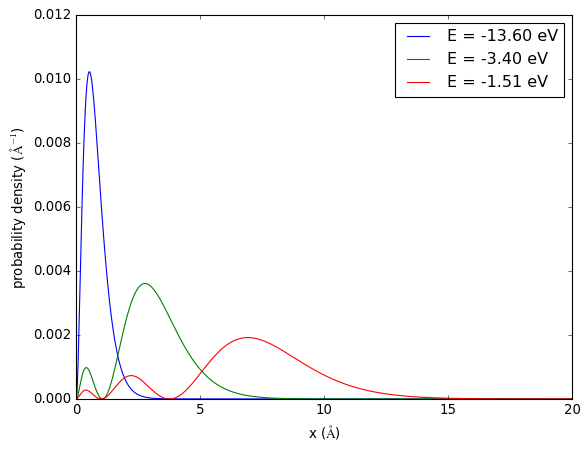

In [5]:
import numpy as np
from scipy import constants as const
from scipy import sparse as sparse
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt
 
hbar = const.hbar
e = const.e
m_e = const.m_e
pi = const.pi
epsilon_0 = const.epsilon_0
joul_to_eV = e
 
def calculate_potential_term(r):
    potential = e**2 / (4.0 * pi * epsilon_0) / r
    potential_term = sparse.diags((potential))
    return potential_term
 
def calculate_angular_term(r):
    angular = l * (l + 1) / r**2
    angular_term = sparse.diags((angular))
    return angular_term
 
def calculate_laplace_three_point(r):
    h = r[1] - r[0]
     
    main_diag = -2.0 / h**2 * np.ones(N)     
    off_diag  =  1.0 / h**2 * np.ones(N - 1)
    laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))
    return laplace_term
     
def build_hamiltonian(r):
    laplace_term =   calculate_laplace_three_point(r)
    angular_term =   calculate_angular_term(r)
    potential_term = calculate_potential_term(r)
     
    hamiltonian = -hbar**2 / (2.0 * m_e) * (laplace_term - angular_term) - potential_term
 
    return hamiltonian
 
def plot(r, densities, eigenvalues):
    plt.xlabel('x ($\\mathrm{\AA}$)')
    plt.ylabel('probability density ($\\mathrm{\AA}^{-1}$)')
     
    energies = ['E = {: >5.2f} eV'.format(eigenvalues[i].real / e) for i in range(3)]
    plt.plot(r * 1e+10, densities[0], color='blue',  label=energies[0])
    plt.plot(r * 1e+10, densities[1], color='green', label=energies[1])
    plt.plot(r * 1e+10, densities[2], color='red',   label=energies[2])
     
    plt.legend()
    plt.show()
    return
 
""" set up horizontal axis and hamiltonian """
N = 2000
l = 0
r = np.linspace(2e-9, 0.0, N, endpoint=False)
hamiltonian = build_hamiltonian(r)

plt.figure(facecolor='white')
""" solve eigenproblem """
number_of_eigenvalues = 30
eigenvalues, eigenvectors = eigs(hamiltonian, k=number_of_eigenvalues, which='SM')
 
""" sort eigenvalue and eigenvectors """
eigenvectors = np.array([x for _, x in sorted(zip(eigenvalues, eigenvectors.T), key=lambda pair: pair[0])])
eigenvalues = np.sort(eigenvalues)
 
""" compute probability density for each eigenvector """
densities = [np.absolute(eigenvectors[i, :])**2 for i in range(len(eigenvalues))]
 
""" plot results """
plot(r, densities, eigenvalues)


Here, I define a class to model the behavior of a hydrogen atom. In the process, I get to solve integrals like the following numerically to test my code:

$$\int_0^{\pi} \int_0^{2\pi} \lvert Y_{l, m_l} \rvert ^2 \sin \theta d \theta d \phi = 1$$

This post consists of a arge block of Python code up front, and then explanations and plots below. Let’s get started!

## Define a class for the hydrogenic atom 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from math import exp, sqrt, pi, cos, sin
from scipy.integrate import dblquad, tplquad, quad
import cmath

class HydrogenicAtom:
    """
    This class models the wavefunctions and energy levels of a hydrogenic atom.
    
    It assumes an infinitely heavy nucleus, so the mass is that of the
    electron.
    
    Masses are in kg, distances are in m
    
    This whole class uses complex numbers and math functions.
    """
    
    def __init__(self, n=1, l=0, ml=0, z=1):
        """
        This sets some instance attributes and a few constant used throughout the
        class.
        
        Leave z at 1 for hydrogen.
        
        Parameters
        ----------    
        n: int
            Principal quantum number.
            
        l: int
            Orbital angular momentum quantum number.
            
        ml: int
            Magnetic quantum number.
            
        z: int
            Number of protons in the nucleus. Defaults to 1.
        """
        self.a0 = 5.29e-11       # m
        self.me = 9.10938356e-31 # kg
        self.e0 = 8.85418782e-12 # Permitivity of free space
        self.e_charge = 1.60217662e-19 # Coulombs, charge of electron
        self.hbar = 1.054571817e-34  # Reduced Planck's constant
        self.n = n
        self.l = l
        self.ml = ml
        self.z = z
        
    def rho(self, r):
        """
        Calculates the rho part of the radial function. It assumes an infinitely
        heavy nucleus.
        
        From Atkins and de Paula, Table 10.1, page 324
        
        Parameters
        ----------
        r: float
            The distance, in meters being calculated
            
        Returns
        -------
        float
            The value of rho.
        """
        return (2 * self.z / self.n / self.a0) * r
    
    def radial(self, r):
        """
        The radial part of the wavefunction
        
        Parameters
        ----------
        r: float
            Radius, in meters
            
        Returns
        -------
        complex
            The value of the radial wavefunction, which only uses the real
            part of the complex value.
            
        Raises
        ------
        Exception
            Raises an exception for invalid n and l
        """
        za32 = (self.z / self.a0) ** (3/2)
        rho = self.rho(r)
        exp_rho = exp(-rho / 2.0)
        
        if self.n == 1 and self.l == 0:  # 1s orbital
            return 2 * za32 * exp_rho
        elif self.n == 2 and self.l == 0:  # 2s orbital
            return (1.0 / sqrt(8)) * za32 * (2.0 - rho) * exp_rho
        elif self.n == 2 and self.l == 1:  # 2p orbital
            return (1.0 / sqrt(24)) * za32 * rho * exp_rho
        elif self.n == 3 and self.l == 0:
            return (1.0 / sqrt(243)) * za32 * (6.0 - 6 * rho + rho ** 2) * exp_rho
        elif self.n == 3 and self.l == 1:
            return (1.0 / sqrt(486)) * za32 * (4.0 - rho) * rho * exp_rho
        elif self.n == 3 and self.l == 2:
            return (1.0 / sqrt(2430)) * za32 * rho ** 2 * exp_rho
        else:
            raise Exception(f'No radial function for {self.n} and {self.l}')
            
    def spherical_harmonic(self, theta, phi):
        """
        Find the value of the spherical harmonic given an quantum numbers
        l, ml and coordinates theta, phi.
        
        From Atkins and de Paula, Table 9.3, page 302
        
        Parameters
        ----------    
        theta: float
            Theta coordinate, from 0 to pi

        phi: float
            Phi coordinate, from 0 to 2*pi
            
        Returns
        -------
        complex
            The value of the spherical harmonic, which is a complex value
            
        Raises
        ------
        Exception
            Raises an Exception for an invalid combination of l and ml
        """
        if self.l == 0 and self.ml == 0:
            return sqrt(1 / 4.0 / pi)
        
        elif self.l == 1 and self.ml == 0:
            return sqrt(3.0 / 4.0 / pi) * cos(theta)
        elif self.l == 1 and self.ml == 1:
            return -sqrt(3.0 / 8.0 / pi) * sin(theta) * cmath.exp(1j * phi)
        elif self.l == 1 and self.ml == -1:
            return -sqrt(3.0 / 8.0 / pi) * sin(theta) * cmath.exp(-1j * phi)
        
        elif self.l == 2 and self.ml == 0:
            return sqrt(5.0 / 16.0 / pi) * (3 * cos(theta)** 2 - 1)
        elif self.l == 2 and self.ml == 1:
            return -sqrt(15.0 / 8.0 / pi) * cos(theta) * sin(theta) * cmath.exp(1j * phi)
        elif self.l == 2 and self.ml == -1:
            return sqrt(15.0 / 8.0 / pi) * cos(theta) * sin(theta) * cmath.exp(-1j * phi)
        elif self.l == 2 and self.ml == 2:
            return sqrt(15.0 / 32.0 / pi) * sin(theta) ** 2 * cmath.exp(2j * phi)
        elif self.l == 2 and self.ml == -2:
            return sqrt(15.0 / 32.0 / pi) * sin(theta) ** 2 * cmath.exp(-2j * phi)
        
        elif self.l == 3 and self.ml == 0:
            return sqrt(7.0 / 16.0 / pi) * (5 * cos(theta) ** 3 - 3 * cos(theta))
        elif self.l == 3 and self.ml == 1:
            return -sqrt(21.0 / 64.0 / pi) * (5 * cos(theta) ** 2 - 1) * sin(theta) * cmath.exp(1j * phi)
        elif self.l == 3 and self.ml == -1:
            return sqrt(21.0 / 64.0 / pi) * (5 * cos(theta) ** 2 - 1) * sin(theta) * cmath.exp(-1j * phi)
        elif self.l == 3 and self.ml == 2:
            return sqrt(105.0 / 32.0 / pi) * sin(theta) ** 2 * cos(theta) * cmath.exp(2j * phi)
        elif self.l == 3 and self.ml == -2:
            return sqrt(105.0 / 32.0 / pi) * sin(theta) ** 2 * cos(theta) * cmath.exp(-2j * phi)
        elif self.l == 3 and self.ml == 3:
            return -sqrt(35.0 / 64.0 / pi) * sin(theta) ** 3 * cmath.exp(3j * phi)
        elif self.l == 3 and self.ml == -3:
            return sqrt(35.0 / 64.0 / pi) * sin(theta) ** 3 * cmath.exp(-3j * phi)
        
        else:
            raise Exception(f'No equation for l={self.l} and ml={self.ml}')
            
    def wavefunction(self, r, theta, phi):
        """
        Returns the value of the wavefunction at the given location.
        
        Parameters
        ----------
        r: float
            The r value, from 0 to infinity
            
        theta: float
            The theta value, from 0 to pi
            
        phi: float
            The phi value, from 0 to 2*pi
            
        Returns
        -------
        complex
            The complex value of the wavefunction.
        """
        return self.radial(r) * self.spherical_harmonic(theta, phi)
            
    def energy(self):
        """
        This calcuates the energy in Joules of the electron at the n level of this
        atoms configuration.
        
        It makes the infinite mas approximation for the nucleus, so the mass in
        the expression is that of the electron.
        
        From page 324 of Atkins and de Paula
        
        Returns
        -------
        float, float
            First float is energy level in joules, second float is energy level in eV
        """
        ev_per_joule = 6.242e+18
        numerator = self.z**2 * self.me * self.e_charge**4
        denominator = 32 * pi**2 * self.e0**2 * self.hbar**2 * self.n**2
        value = numerator / denominator
        joules = -value
        ev = joules * ev_per_joule
        return joules, ev
    
    def mean_orbital_radius(self):
        """
        Returns the mean orbital radius of the given state of this atom.
        It does this by integration.
        
        Returns
        -------
        float
            The mean orbital radius
        """
        second_point_guess = 10 * self.n * self.a0
        def integrand(r):
            return r**3 * self.radial(r)**2
        radius, _ = quad(integrand, 0, 1, points=[0, second_point_guess])
        return radius

## Check the spherical harmonics 

Make sure all the spherical harmonics are normalized. That means each of the the spherical harmonic functions must stasify the following expression:\
$$\int_0^{\pi} \int_0^{2\pi} \lvert Y_{l, m_l} \rvert ^2 \sin \theta d \theta d \phi = 1$$\
The next block of code takes the spherical harmonic for each parameter set of l and ml and numerically integrates it to ensure that the result is 1.0, within floating point precision. A report of the parameters and the results follows, and they all integrate to approximately 1.0! Success!

In [7]:
parameters = [
    { 'n': 3, 'l': 0, 'ml': 0 },
    { 'n': 3, 'l': 1, 'ml': 0 },
    { 'n': 3, 'l': 1, 'ml': 1 },
    { 'n': 3, 'l': 1, 'ml': -1 },
    { 'n': 3, 'l': 2, 'ml': 0 },
    { 'n': 3, 'l': 2, 'ml': 1 },
    { 'n': 3, 'l': 2, 'ml': -1 },
    { 'n': 3, 'l': 2, 'ml': 2 },
    { 'n': 3, 'l': 2, 'ml': -2 },
    { 'n': 3, 'l': 3, 'ml': 0 },
    { 'n': 3, 'l': 3, 'ml': 1 },
    { 'n': 3, 'l': 3, 'ml': -1 },
    { 'n': 3, 'l': 3, 'ml': 2 },
    { 'n': 3, 'l': 3, 'ml': -2 },
    { 'n': 3, 'l': 3, 'ml': 3 },
    { 'n': 3, 'l': 3, 'ml': -3 }
]

for p in parameters:
    ha = HydrogenicAtom(n=p['n'], l=p['l'], ml=p['ml'])
    def integrand(phi,theta):
        value = ha.spherical_harmonic(theta, phi)
        return abs(value) ** 2 * sin(theta).real
    p['result'], _ = dblquad(integrand, 0, pi, 0, 2 * pi)
    
for p in parameters:
    print(p)

{'n': 3, 'l': 0, 'ml': 0, 'result': 0.9999999999999999}
{'n': 3, 'l': 1, 'ml': 0, 'result': 1.0}
{'n': 3, 'l': 1, 'ml': 1, 'result': 0.9999999999999999}
{'n': 3, 'l': 1, 'ml': -1, 'result': 0.9999999999999999}
{'n': 3, 'l': 2, 'ml': 0, 'result': 1.0000000000000002}
{'n': 3, 'l': 2, 'ml': 1, 'result': 0.9999999999999999}
{'n': 3, 'l': 2, 'ml': -1, 'result': 0.9999999999999999}
{'n': 3, 'l': 2, 'ml': 2, 'result': 1.0}
{'n': 3, 'l': 2, 'ml': -2, 'result': 1.0}
{'n': 3, 'l': 3, 'ml': 0, 'result': 1.0}
{'n': 3, 'l': 3, 'ml': 1, 'result': 1.0000000000000004}
{'n': 3, 'l': 3, 'ml': -1, 'result': 1.0000000000000004}
{'n': 3, 'l': 3, 'ml': 2, 'result': 0.9999999999999999}
{'n': 3, 'l': 3, 'ml': -2, 'result': 0.9999999999999999}
{'n': 3, 'l': 3, 'ml': 3, 'result': 1.0000000000000002}
{'n': 3, 'l': 3, 'ml': -3, 'result': 1.0000000000000002}


## Plot of the radial functions

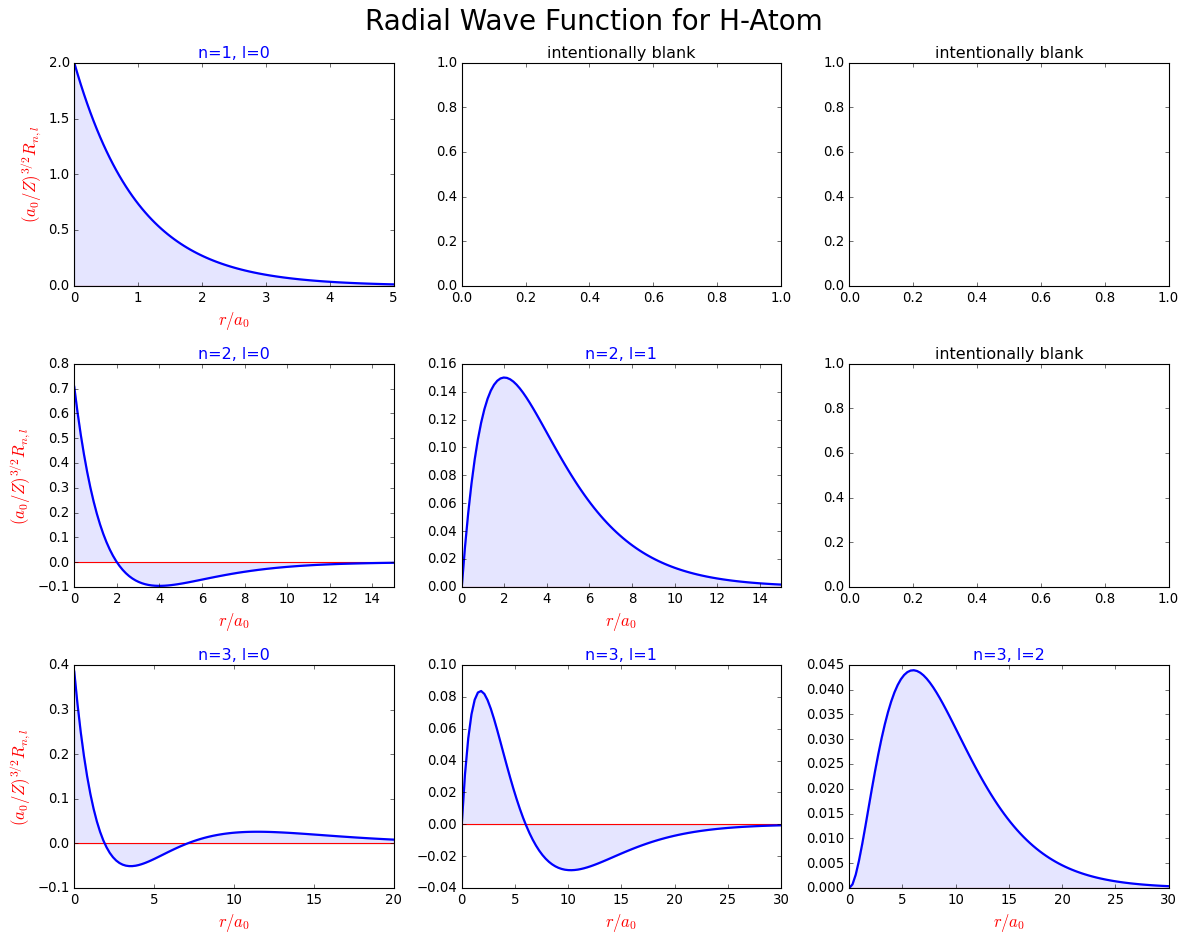

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), facecolor='white')

# Just so I can access instance variables in an instance to make the dictionary.
ha = HydrogenicAtom()
yscaler = (ha.z / ha.a0)**(3/2)


parameters = [
    {'n': 1, 'l': 0, 'x_scaler': 5, 'yscaler':  yscaler },
    {'n': 2, 'l': 0, 'x_scaler': 15, 'yscaler': yscaler },
    {'n': 3, 'l': 0, 'x_scaler': 20, 'yscaler': yscaler },
    {'n': 2, 'l': 1, 'x_scaler': 15, 'yscaler': yscaler },
    {'n': 3, 'l': 1, 'x_scaler': 30, 'yscaler': yscaler },
    {'n': 3, 'l': 2, 'x_scaler': 30, 'yscaler': yscaler }
]

for p in parameters:
    row = p['n'] - 1
    col = p['l']
    ha = HydrogenicAtom(n=p['n'], l=p['l'])
    xs = np.linspace(0, ha.a0 * p['x_scaler'], 100)
    xs_labels = xs / ha.a0  # so that the x axis is labeled in units of a0
    ys = [ha.radial(r) / p['yscaler'] for r in xs]
    ax = axs[row, col]
    ax.set_title(f'n={p["n"]}, l={p["l"]}', color='b')
    ax.set_xlim(min(xs_labels), max(xs_labels))
    if col == 0:
        ax.set_ylabel('$(a_0/Z)^{3/2}R_{n,l}$', color='r', fontsize=15)
    ax.set_xlabel('$r/a_0$', color='r', fontsize=15)
    ax.axhline(0.0, color='r')
    ax.plot(xs_labels, ys, color='b', linewidth=2)
    ax.fill_between(xs_labels, ys, 0, alpha=0.1)

    
axs[0, 1].set_title('intentionally blank')
axs[0, 2].set_title('intentionally blank')
axs[1, 2].set_title('intentionally blank')
axs[0, 1].set_facecolor('white')
axs[0, 2].set_facecolor('white')
axs[1, 2].set_facecolor('white')
   
fig.suptitle('Radial Wave Function for H-Atom', fontsize=25)    
plt.tight_layout()

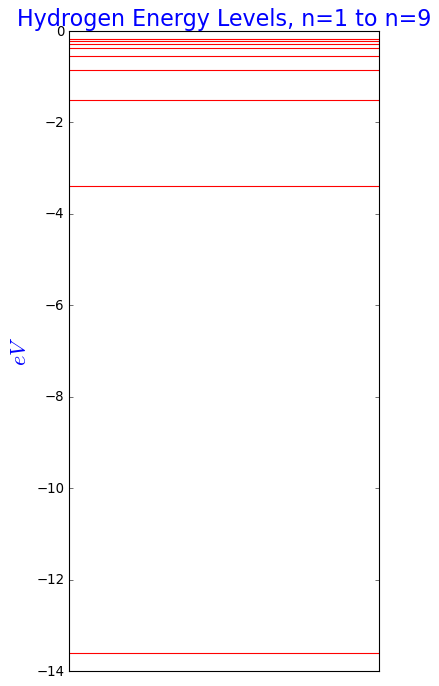

In [28]:
ys = []
for n in range(1, 10):
    ha = HydrogenicAtom(n=n)
    _, ev = ha.energy()
    ys.append((n, round(ev, 2)))

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 10), facecolor='white')
ax.set_ylim(-14.0, 0.0)
ax.set_xticks([])
ax.set_ylabel('$eV$', size=20, color='b')
ax.set_title('Hydrogen Energy Levels, n=1 to n=9', size=20, color='b')
for y in ys:
    ax.axhline(y[1], color='r')
